## PRESCRIPTIVE ANALYSIS

In [59]:
import glob
import os
import pandas as pd
import matplotlib as plot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
import warnings

# Suppress only DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [60]:
merged_df = pd.read_csv("merged_cleandata.csv")
demographic_df = pd.read_csv("demographic_cleandata.csv")

In [61]:
merged_df.shape

(90539, 12)

In [62]:
demographic_df.shape

(25, 7)

In [63]:
merged_df['time'] = pd.to_datetime(merged_df['time'])
merged_df['hour'] = merged_df['time'].dt.hour
# Extract date for aggregation
merged_df['date'] = merged_df['time'].dt.date
patients = merged_df['patient_id'].unique()

<html>
<body>
    <h1>
       Hypoglycemia Analytics
      </h1>
<h2>Question 1 : Which patients are experiencing longer hypoglycemia incidents, and when should they be advised to take carbs to restore their glucose levels?</h2>
<h2>Why this is important</h2>
      <p>
        Identifying prolonged hypoglycemia is critical because sustained low blood sugar can cause
        severe complications such as confusion, seizures, coma, and even death. The
        <strong>duration</strong> of hypoglycemia matters as much as the frequency — even a single long
        event poses significant risk. By detecting when glucose remains below the safe range for at
        least <strong>15 continuous minutes</strong>, we can intervene early with carbohydrate intake to
        prevent serious outcomes.
      </p>

<div class="grid">
        <div>
          <h2>Our approach</h2>
          <ul>
            <li>Mark continuous periods where glucose stays <em>below range</em> (hypoglycemia).</li>
            <li>Log the <strong>start time</strong> and <strong>end time</strong> of each hypoglycemia event.</li>
            <li>Calculate the <strong>duration</strong> in 5-minute intervals (CGM sampling).</li>
            <li>Flag events lasting &ge; 15 minutes as <strong>critical</strong> and generate
                <strong>carb recommendations every 15 minutes</strong> until recovery.</li>
          </ul>

<h2>Notes & assumptions</h2>
      <ul class="muted">
        <li>Sampling frequency is 5 minutes; “continuous 15 minutes” equals 3 sequential readings.</li>
        <li>“Below range” threshold is typically &lt; 70 mg/dL</li>
        <li>Recommendations reflect general guidance</li>
      </ul>
    </section>
  </main>
</body>
</html>

All hypoglycemia events (start & end with recommendation):
    patient_id        date  event_id          start_time            end_time  \
0    HUPA0001P  2018-06-13       4.0 2018-06-13 21:15:00 2018-06-13 21:30:00   
1    HUPA0001P  2018-06-14       6.0 2018-06-14 05:00:00 2018-06-14 06:20:00   
2    HUPA0001P  2018-06-24       4.0 2018-06-24 01:00:00 2018-06-24 01:55:00   
3    HUPA0001P  2018-06-26       4.0 2018-06-26 05:15:00 2018-06-26 05:45:00   
4    HUPA0002P  2018-06-14       2.0 2018-06-14 00:35:00 2018-06-14 08:25:00   
..         ...         ...       ...                 ...                 ...   
406  HUPA0028P  2022-05-14       2.0 2022-05-14 04:35:00 2022-05-14 06:50:00   
407  HUPA0028P  2022-05-14       4.0 2022-05-14 07:25:00 2022-05-14 08:10:00   
408  HUPA0028P  2022-05-15       2.0 2022-05-15 15:15:00 2022-05-15 16:15:00   
409  HUPA0028P  2022-05-15       4.0 2022-05-15 19:00:00 2022-05-15 19:15:00   
410  HUPA0028P  2022-05-17       2.0 2022-05-17 18:30:00 2022

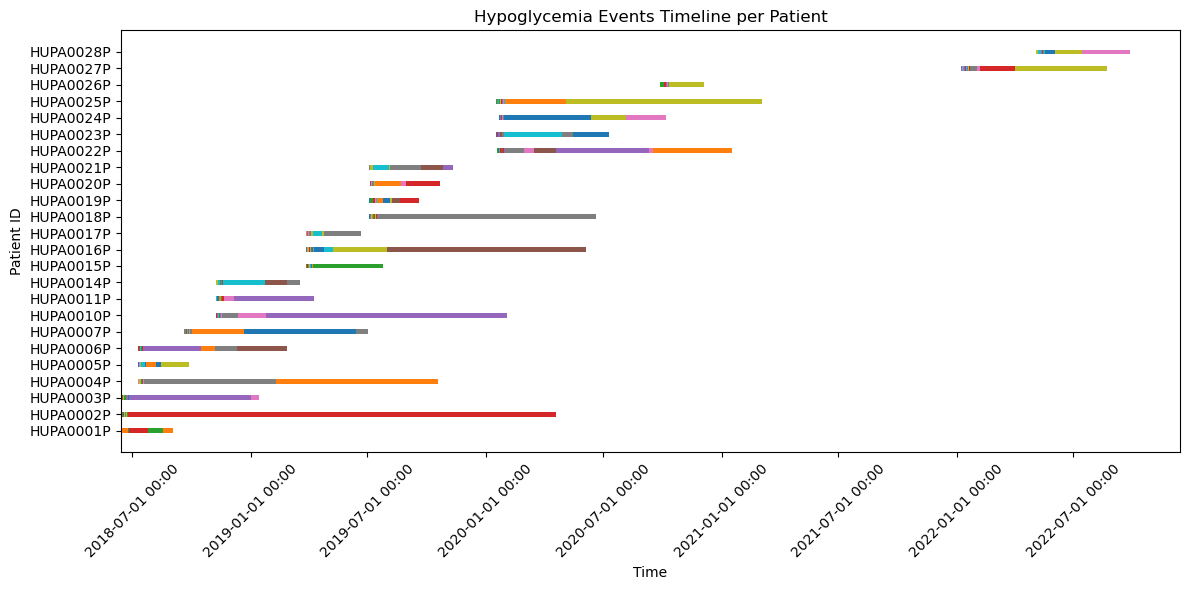

In [65]:

# Create below_range flag (1 = hypoglycemia, 0 = normal)
merged_df['below_range'] = merged_df['glucose_range_level'].str.strip().str.lower().apply(
    lambda x: 1 if x == 'below range' else 0
)
# Hypo rows finder
def consecutive_hypo_rows(group, min_length=3):
    group = group.copy()
    group['event_group'] = (group['below_range'] != group['below_range'].shift()).cumsum()
    
    hypo_events = group[group['below_range'] == 1].groupby('event_group')
    
    result = []
    for eid, rows in hypo_events:
        if len(rows) >= min_length:
            duration_intervals = len(rows)   # how many 5-min intervals
            num_blocks = duration_intervals // 3  # how many 15-min blocks
            
            # Store the event with patient, date, start & end
            result.append({
                'patient_id': rows['patient_id'].iloc[0],
                'date': rows['date'].iloc[0],
                'event_id': eid,
                'start_time': rows['time'].iloc[0],
                'end_time': rows['time'].iloc[-1],
                'duration_intervals': duration_intervals*5,
                'recommendation': f"Take carbs every 15 min ({num_blocks} times)" if num_blocks > 0 else "Monitor only"
            })
    return pd.DataFrame(result)

# Apply per patient per day
hypo_events = merged_df.groupby(['patient_id', 'date']).apply(consecutive_hypo_rows).reset_index(drop=True)

print("All hypoglycemia events (start & end with recommendation):")
print(hypo_events)


# Convert times to datetime 
hypo_events['start_time'] = pd.to_datetime(hypo_events['start_time'])
hypo_events['end_time'] = pd.to_datetime(hypo_events['end_time'])

fig, ax = plt.subplots(figsize=(12, 6))

# Plot events as horizontal bars
for i, row in hypo_events.iterrows():
    ax.barh(row['patient_id'], 
            (row['end_time'] - row['start_time']).total_seconds()/60, 
            left=row['start_time'], 
            height=0.3, 
            label=row['recommendation'] if i==0 else "")

# Format x-axis to show full datetime
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)
plt.xlabel("Time")
plt.ylabel("Patient ID")
plt.title("Hypoglycemia Events Timeline per Patient")
plt.tight_layout()
plt.show()


<!doctype html>
<html lang="en">
<body>
  <h2>What the chart shows</h2>
  <ul>
    <li><strong>Bars</strong> represent hypoglycemia incidents.</li>
    <li><strong>Start point</strong> = when glucose first dropped below the safe range.</li>
    <li><strong>End point</strong> = when glucose returned to normal.</li>
    <li><strong>Length</strong> = duration of the event (longer bars = more severe incidents).</li>
  </ul>

  <h2>Key Insight</h2>
  <ul>
    <li>You can quickly see which patients experience <strong>short vs. long</strong> episodes.</li>
  </ul>

  <h3>Examples</h3>
  <ul>
    <li>If one patient has <strong>longer bars</strong>, they’re at <strong>higher risk</strong> and need earlier carb interventions.</li>
    <li>If another patient has mostly <strong>short events</strong>, their glucose usually recovers faster.</li>
  </ul>
  ------------------------------------------------------------------------------------------------------------------------------------------
</body>
</html>

<html>
<body>
    <h1>Hypoglycemia Frequency</h1>
    <h2>Question 2:</h2>
    <p>What is the frequency of hypoglycemic incidents experienced by each patient during the study period?</p>

<h2>Why it is important:</h2>
    <p>
        Repeated exposure to low blood sugar can reduce the body's warning signs, 
        such as shakiness or a fast heartbeat. A person may not realize their blood sugar 
        is dropping until it reaches a dangerously low level, increasing the risk of a 
        severe, life-threatening event.
    </p>
</body>
</html>


Number of hypoglycemia events per patient with recommendations:
    patient_id        date  num_hypo_events  \
0    HUPA0001P  2018-06-13                1   
1    HUPA0001P  2018-06-14                1   
2    HUPA0001P  2018-06-24                1   
3    HUPA0001P  2018-06-26                1   
4    HUPA0002P  2018-06-14                3   
..         ...         ...              ...   
201  HUPA0028P  2022-05-11                4   
202  HUPA0028P  2022-05-12                2   
203  HUPA0028P  2022-05-14                2   
204  HUPA0028P  2022-05-15                2   
205  HUPA0028P  2022-05-17                1   

                                        recommendation  
0    Low frequency – Routine monitoring; follow 15–...  
1    Low frequency – Routine monitoring; follow 15–...  
2    Low frequency – Routine monitoring; follow 15–...  
3    Low frequency – Routine monitoring; follow 15–...  
4    Moderate frequency – Carry quick-acting carbs ...  
..                          

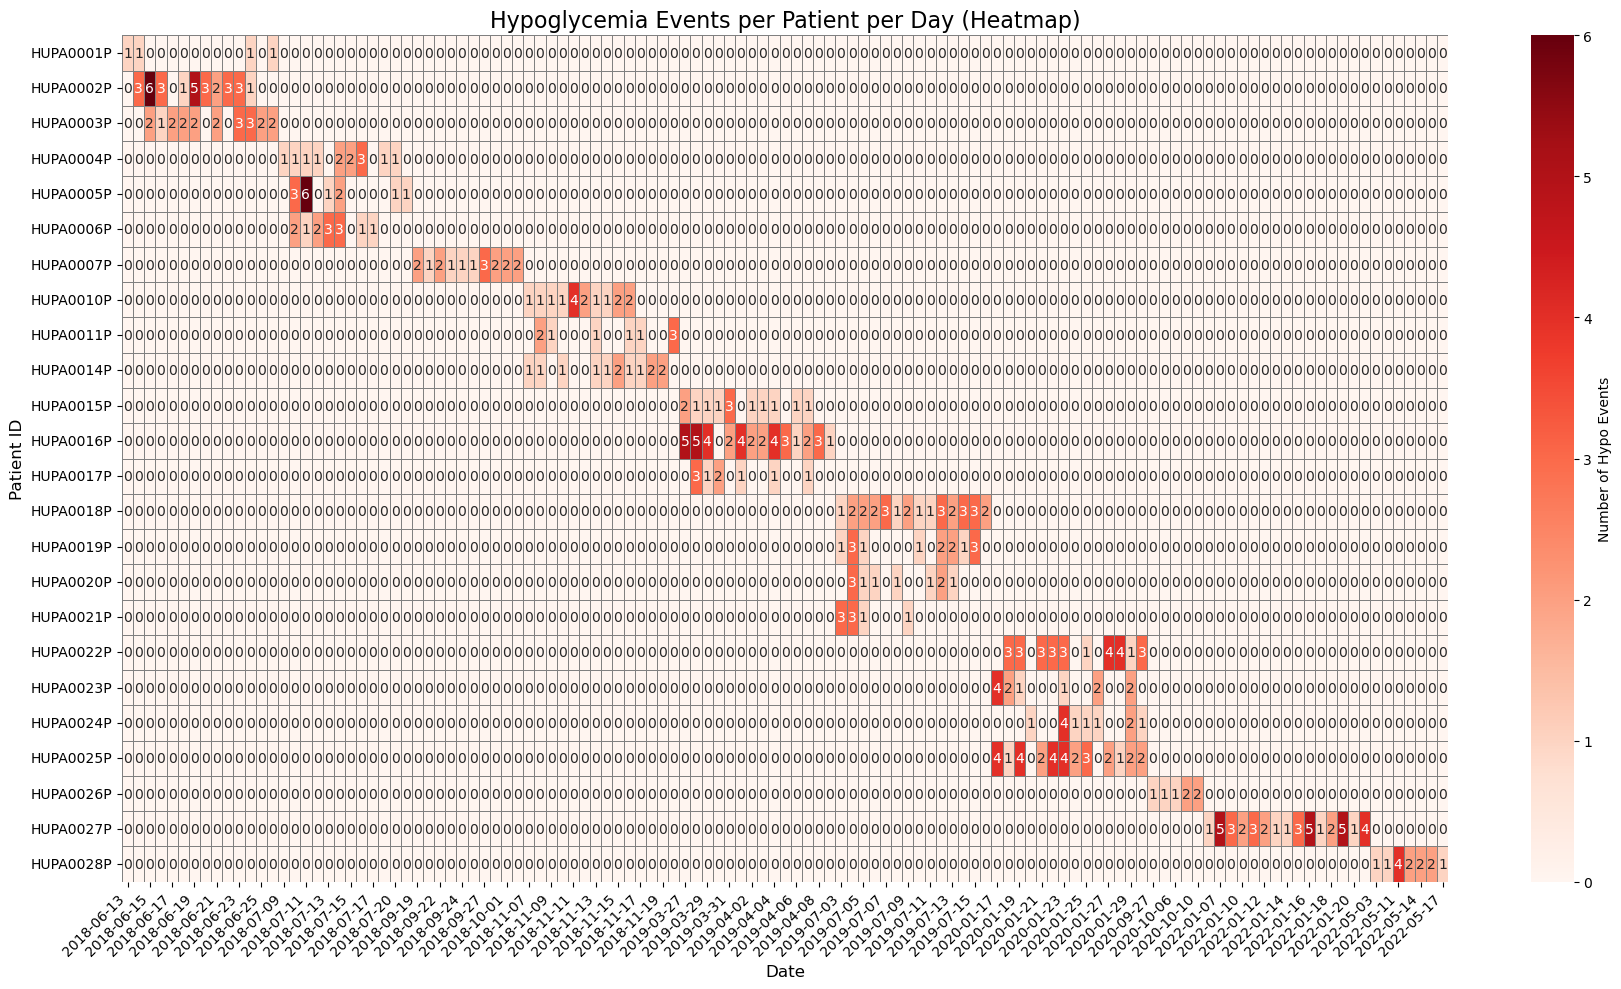

In [68]:
# Count frequency of hypoglycemic events per day per patient
events_per_day = (
    hypo_events.groupby(['patient_id', 'date'])['event_id']
    .count()
    .reset_index()
    .rename(columns={'event_id': 'num_hypo_events'})
)

# Function to give recommendations
def prescribe_recommendation(freq):
    if freq >= 5:
        return "High frequency – Review insulin dosage and meal planning with clinician."
    elif 2 <= freq <= 4:
        return "Moderate frequency – Carry quick-acting carbs and check glucose more often."
    elif freq == 1:
        return "Low frequency – Routine monitoring; follow 15–15 rule if hypo occurs."
    else:
        return "No incidents – Maintain current regimen with routine checks."

events_per_day['recommendation'] = events_per_day['num_hypo_events'].apply(prescribe_recommendation)

print("\nNumber of hypoglycemia events per patient with recommendations:")
print(events_per_day)

# Pivot table for heatmap
heatmap_data = events_per_day.pivot_table(
    index="patient_id",
    columns="date",
    values="num_hypo_events",
    fill_value=0
).astype(int)  


plt.figure(figsize=(18, 10))
sns.heatmap(
    heatmap_data, 
    cmap="Reds", 
    linewidths=0.5, 
    linecolor="gray",
    annot=True, 
    fmt="d",
    cbar_kws={'label': 'Number of Hypo Events'}
)

plt.title("Hypoglycemia Events per Patient per Day (Heatmap)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Patient ID", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


<html>
<body>
    <h2>Key Insights</h2>

<p>The data allows us to rank patients by risk:</p>
    <ul>
        <li><strong>High-risk:</strong> frequent events → “Review insulin and meal planning.”</li>
        <li><strong>Medium-risk:</strong> occasional events → “Carry quick-acting carbs.”</li>
        <li><strong>Low-risk:</strong> minimal events → “Routine monitoring.”</li>
    </ul>

<p><strong>Actionable insight:</strong> This chart helps to identify the frequency of hypoglycemic incidents.</p>
--------------------------------------------------------------------------------------------------------------------------------------------

</body>
</html>

<html>
<body>
    <h1>Hypoglycemia Alert Recommendations</h1>
    <h2>Question 3:</h2>
    <p>For each hypoglycemia event, how can we create 15-minute interval recommendations to help the patient prevent dangerously low blood sugar?</p>

<h2>Why this is important:</h2>
    <p>Hypoglycemia (low blood sugar) can become dangerous if not treated promptly. By creating 15-minute interval recommendations, patients get timely reminders to consume carbohydrates, which helps:</p>
    <ul>
        <li>Prevent their blood sugar from dropping to a critically low level.</li>
        <li>Reduce the risk of severe hypoglycemia, which can cause confusion, loss of consciousness, or even life-threatening events.</li>
        <li>Support proactive, rather than reactive, management of glucose levels.</li>
    </ul>
</body>
</html>

      patient_id        date  event_id recommendation_time  \
0      HUPA0001P  2018-06-13       4.0 2018-06-13 21:30:00   
1      HUPA0001P  2018-06-13       4.0 2018-06-13 21:45:00   
2      HUPA0001P  2018-06-13       4.0 2018-06-13 22:00:00   
3      HUPA0001P  2018-06-13       4.0 2018-06-13 22:15:00   
4      HUPA0001P  2018-06-13       4.0 2018-06-13 22:30:00   
...          ...         ...       ...                 ...   
10661  HUPA0028P  2022-05-17       2.0 2022-05-17 19:00:00   
10662  HUPA0028P  2022-05-17       2.0 2022-05-17 19:15:00   
10663  HUPA0028P  2022-05-17       2.0 2022-05-17 19:30:00   
10664  HUPA0028P  2022-05-17       2.0 2022-05-17 19:45:00   
10665  HUPA0028P  2022-05-17       2.0 2022-05-17 20:00:00   

                              message  
0      Take 15g carb and wait 15 mins  
1      Take 15g carb and wait 15 mins  
2      Take 15g carb and wait 15 mins  
3      Take 15g carb and wait 15 mins  
4      Take 15g carb and wait 15 mins  
...            

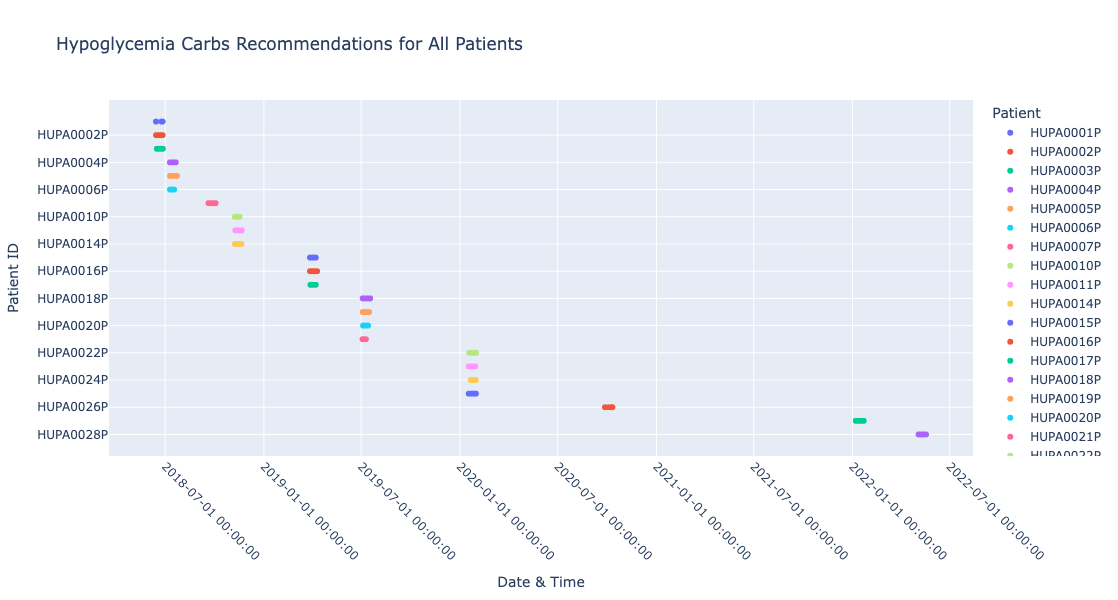

In [71]:
def add_hypo_recommendations(hypo_events):
    recommendations = []
    
    for _, row in hypo_events.iterrows():
        patient_id = row['patient_id']
        date = row['date']
        start_time = row['start_time']
        
        duration_intervals = row['duration_intervals']
        
        num_blocks = int(duration_intervals // 3)  
        
        for i in range(num_blocks):
            rec_time = start_time + pd.Timedelta(minutes=15 * (i + 1))
            recommendations.append({
                'patient_id': patient_id,
                'date': date,
                'event_id': row['event_id'],
                'recommendation_time': rec_time,
                'message': 'Take 15g carb and wait 15 mins'
            })
    
    return pd.DataFrame(recommendations)

recommendations = add_hypo_recommendations(hypo_events)
print(recommendations)

# Ensure datetime
recommendations['recommendation_time'] = pd.to_datetime(recommendations['recommendation_time'])

# Sort patients for consistent ordering
recommendations['patient_id'] = pd.Categorical(
    recommendations['patient_id'],
    categories=sorted(recommendations['patient_id'].unique()),
    ordered=True
)

# Scatter plot: x = recommendation time, y = patient_id
fig = px.scatter(
    recommendations,
    x='recommendation_time',
    y='patient_id',
    color='patient_id',
    hover_data=['event_id', 'message'],
    title='Hypoglycemia Carbs Recommendations for All Patients',
)

# Format x-axis to show full datetime
fig.update_xaxes(
    tickformat='%Y-%m-%d %H:%M:%S',
    tickangle=45
)

# adjust figure size
fig.update_layout(
    width=1400,
    height=600,
    yaxis_title='Patient ID',
    xaxis_title='Date & Time',
    legend_title='Patient',
)

fig.show()

<html>
<body>
    <h2>Key Insights:</h2>
    <ul>
        <li>The recommendations table and scatter plot show <strong>when</strong> and <strong>for which patient</strong> the carb intake is needed.</li>
        <li>Patients with longer or more frequent hypoglycemia events have more 15-minute intervals, indicating <strong>higher risk</strong> and the need for closer monitoring.</li>
    </ul>
---------------------------------------------------------------------------------------------------------------------------------------------

</body>
</html>

<html>
<body>
    <h1>Hypoglycemia Risk Categorization</h1>
    <h2>Question 4:</h2>
    <p>How can we categorize patients based on the severity and frequency of hypoglycemia events to identify those who need urgent or closer medical attention?</p>

<h2>Why this is important:</h2>
    <ul>
        <li>Some patients may experience long or frequent hypoglycemia events, which increases the risk of severe complications.</li>
        <li>Risk categorization allows clinicians to prioritize patients who require immediate intervention, insulin adjustment, or lifestyle modifications.</li>
        <li>It supports proactive management, reducing the likelihood of dangerously low blood sugar episodes.</li>
    </ul>
</body>

    patient_id        date  num_hypo_events  longest_event_minutes  \
1    HUPA0001P  2018-06-14                1                   85.0   
2    HUPA0001P  2018-06-24                1                   60.0   
4    HUPA0002P  2018-06-14                3                  475.0   
5    HUPA0002P  2018-06-15                6                   60.0   
6    HUPA0002P  2018-06-16                3                  225.0   
..         ...         ...              ...                    ...   
198  HUPA0027P  2022-01-21                4                   20.0   
200  HUPA0028P  2022-05-07                1                  120.0   
201  HUPA0028P  2022-05-11                4                  110.0   
203  HUPA0028P  2022-05-14                2                  140.0   
204  HUPA0028P  2022-05-15                2                   65.0   

                                 risk_category  
1          High Severity - Immediate Attention  
2          High Severity - Immediate Attention  
4          H

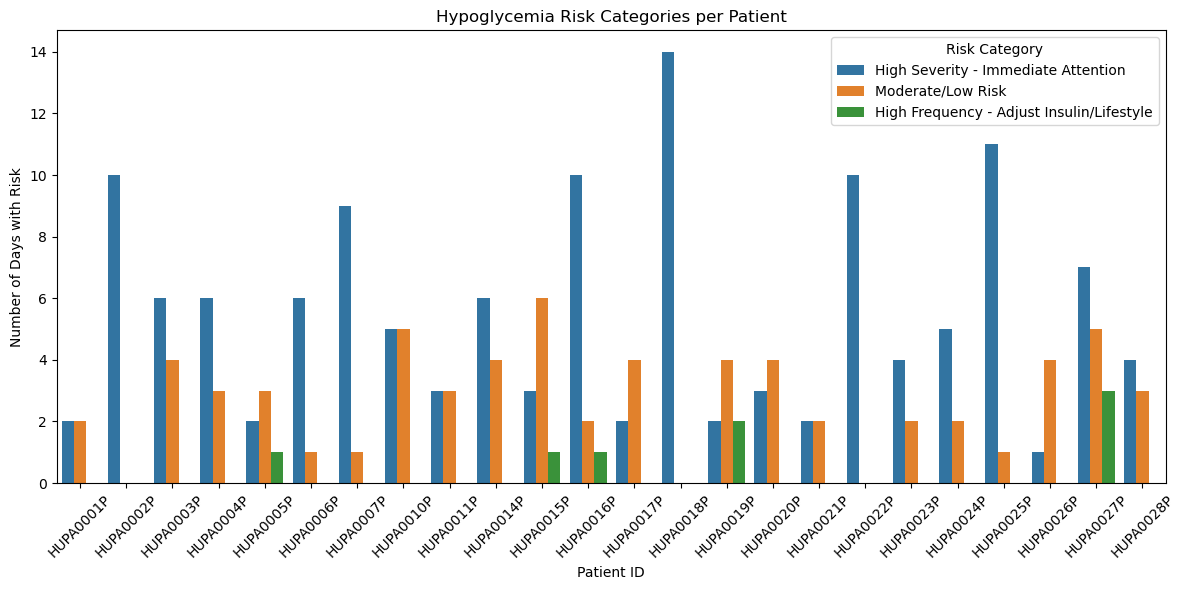

In [74]:
hypo_summary = hypo_events.groupby(['patient_id', 'date']).agg(
    num_hypo_events=('event_id', 'count'),
    longest_event_minutes=('duration_intervals', 'max')  
).reset_index()

# Define risk categories
def assess_risk(row):
    if row['longest_event_minutes'] >= 60:
        return 'High Severity - Immediate Attention'
    elif row['num_hypo_events'] >= 3:
        return 'High Frequency - Adjust Insulin/Lifestyle'
    else:
        return 'Moderate/Low Risk'

# Apply risk assessment
hypo_summary['risk_category'] = hypo_summary.apply(assess_risk, axis=1)

# View top risks
top_risks = hypo_summary[hypo_summary['risk_category'] != 'Moderate/Low Risk']

print(top_risks[['patient_id', 'date', 'num_hypo_events', 'longest_event_minutes', 'risk_category']])

# Count of each risk category per patient
risk_counts = hypo_summary.groupby(['patient_id', 'risk_category']).size().reset_index(name='count')

plt.figure(figsize=(12,6))
sns.barplot(data=risk_counts, x='patient_id', y='count', hue='risk_category')

plt.title('Hypoglycemia Risk Categories per Patient')
plt.xlabel('Patient ID')
plt.ylabel('Number of Days with Risk')
plt.xticks(rotation=45)
plt.legend(title='Risk Category')
plt.tight_layout()
plt.show()

<html>
<body>
    <h2>Key Insight from the Result:</h2>
    <ul>
        <li>Patients with longest events ≥ 60 minutes are classified as <strong>High Severity</strong>, signaling the need for immediate attention.</li>
        <li>Patients with three or more hypoglycemia events are classified as <strong>High Frequency</strong>, indicating the need for insulin or lifestyle adjustments.</li>
        <li>Those with fewer and shorter events fall into <strong>Moderate/Low Risk</strong>, suggesting current management is largely effective.</li>
        <li>This risk assessment helps clinicians allocate resources efficiently and focus on high-risk individuals first.</li>
    </ul>
----------------------------------------------------------------------------------------------------------------------------------------------

</body>
</html>

<h3>Question 5</h3>
<p>How long do patients experience <strong>hyperglycemic incidents</strong> (glucose &gt;180 mg/dL) during the monitoring period?</p>

<h3>Why It Is Important</h3>
<p>Identifying longer hyperglycemic events is crucial for preventing severe, often irreversible health complications that result from prolonged exposure to high blood sugar. While short, occasional blood sugar spikes may be harmless, consistent hyperglycemia, also known as <strong>chronic hyperglycemia</strong>, can damage vital organs and systems throughout the body.</p>

All hyperglycemia events (start & end with recommendation):
    patient_id        date  event_id          start_time            end_time  \
0    HUPA0001P  2018-06-13       1.0 2018-06-13 18:40:00 2018-06-13 19:55:00   
1    HUPA0001P  2018-06-14      18.0 2018-06-14 11:10:00 2018-06-14 13:40:00   
2    HUPA0001P  2018-06-14      24.0 2018-06-14 17:00:00 2018-06-14 20:55:00   
3    HUPA0001P  2018-06-15       5.0 2018-06-15 00:25:00 2018-06-15 04:55:00   
4    HUPA0001P  2018-06-15      11.0 2018-06-15 12:15:00 2018-06-15 13:00:00   
..         ...         ...       ...                 ...                 ...   
788  HUPA0028P  2022-05-16       2.0 2022-05-16 10:05:00 2022-05-16 10:30:00   
789  HUPA0028P  2022-05-16       4.0 2022-05-16 15:40:00 2022-05-16 16:35:00   
790  HUPA0028P  2022-05-17       2.0 2022-05-17 01:35:00 2022-05-17 03:10:00   
791  HUPA0028P  2022-05-17       4.0 2022-05-17 09:15:00 2022-05-17 13:05:00   
792  HUPA0028P  2022-05-17       6.0 2022-05-17 15:55:00 202

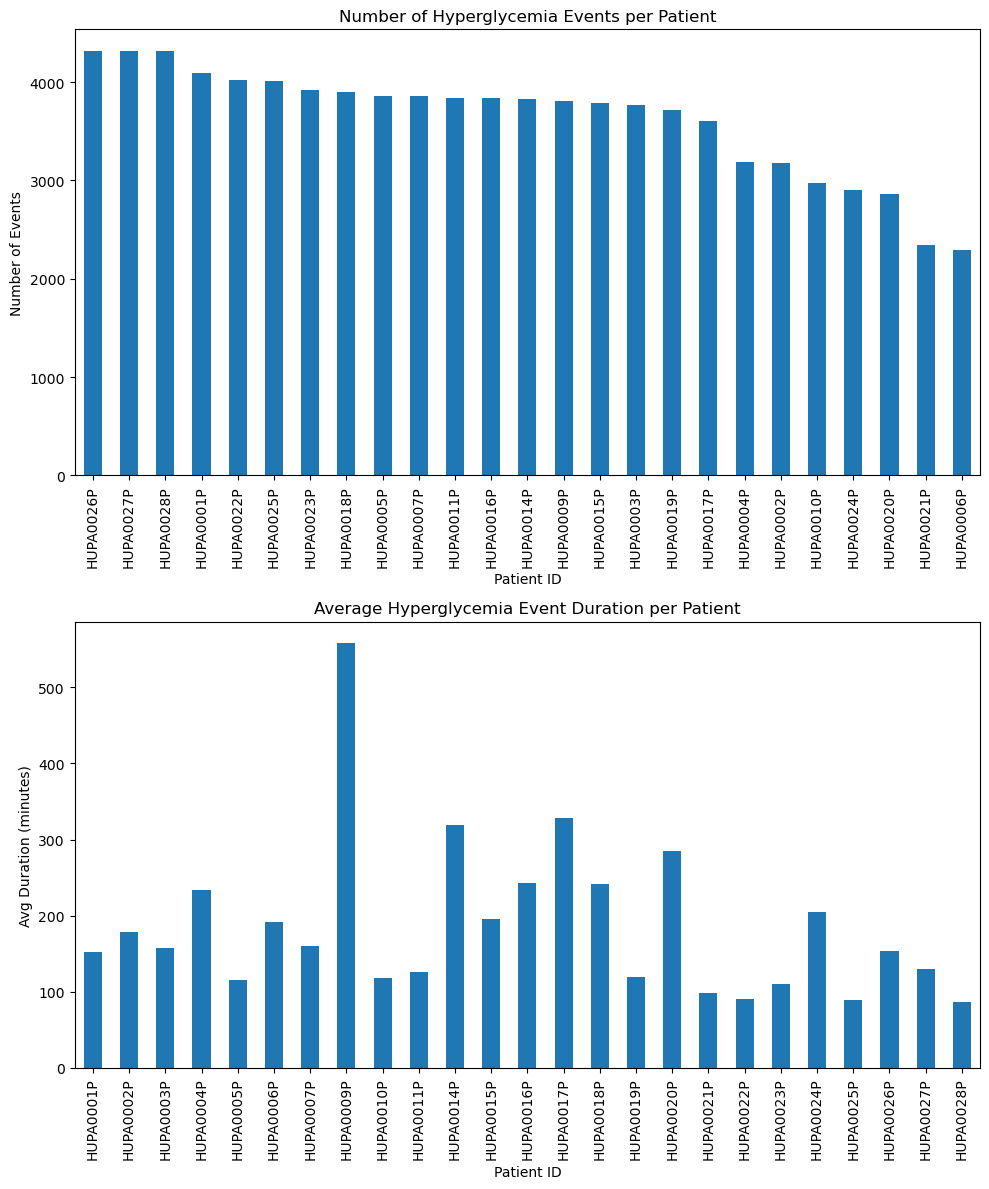

In [77]:
# Create above_range flag (1 = hyperglycemia, 0 = normal)
merged_df['above_range'] = merged_df['glucose_range_level'].str.strip().str.lower().apply(
    lambda x: 1 if x == 'above range' else 0
)

# Hyperglycemia rows finder
def consecutive_hyper_rows(group, min_length=3):
    group = group.copy()
    group['event_group'] = (group['above_range'] != group['above_range'].shift()).cumsum()
    
    hyper_events = group[group['above_range'] == 1].groupby('event_group')
    
    result = []
    for eid, rows in hyper_events:
        if len(rows) >= min_length:
            duration_intervals = len(rows)   # number of 5-min intervals
            num_blocks = duration_intervals // 3  # number of 15-min blocks
            
            result.append({
                'patient_id': rows['patient_id'].iloc[0],
                'date': rows['date'].iloc[0],
                'event_id': eid,
                'start_time': rows['time'].iloc[0],
                'end_time': rows['time'].iloc[-1],
                'duration_intervals': duration_intervals*5,
                'recommendation': f"Take corrective action every 15 min ({num_blocks} times)" if num_blocks > 0 else "Monitor only"
            })
    return pd.DataFrame(result)

# Apply per patient per day
hyper_events = merged_df.groupby(['patient_id', 'date']).apply(consecutive_hyper_rows).reset_index(drop=True)

print("All hyperglycemia events (start & end with recommendation):")
print(hyper_events)

fig, axes = plt.subplots(2, 1, figsize=(10, 12))  # 3 rows, 1 column

# Events per patient
merged_df['patient_id'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title("Number of Hyperglycemia Events per Patient")
axes[0].set_xlabel("Patient ID")
axes[0].set_ylabel("Number of Events")
axes[0].tick_params(axis='x', rotation=90)

# Average duration per patient
hyper_events.groupby('patient_id')['duration_intervals'].mean().plot(kind='bar', ax=axes[1])
axes[1].set_title("Average Hyperglycemia Event Duration per Patient")
axes[1].set_xlabel("Patient ID")
axes[1].set_ylabel("Avg Duration (minutes)")
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


<h3>Key Insight from the Table:</h3>
<ul>
  <li><strong>Event duration varies widely:</strong> Some patients have short events (~30–50 minutes), while others experience prolonged hyperglycemia (&gt;4 hours).</li>
  <li><strong>Repeated interventions are often needed:</strong> The “recommendation” column indicates that patients may require multiple corrective actions per event, showing that single interventions are often insufficient.</li>
  <li><strong>Patient-specific patterns emerge:</strong> Certain patients (e.g., HUPA0001P) have multiple long-duration events on the same day, suggesting individualized management strategies are necessary.</li>
  <li><strong>Overall hyperglycemia burden:</strong> By summing durations across all events per patient, we can quantify total exposure to high glucose, which is critical for risk assessment.</li>
</ul>
--------------------------------------------------------------------------------------------------------------------------------------------------

<h2>Hyper/Hypo Incidents Analysis per patient </h2>
<h3>Question 6</h3>
<p>For each patient, are they more affected by <strong>hyperglycemia</strong>, <strong>hypoglycemia</strong>, or equally affected by both, and how should their treatment or monitoring plan be adjusted accordingly?</p>

<h3>Why It Is Important</h3>
<p>Knowing whether a patient is predominantly hyperglycemic or hypoglycemic helps clinicians <strong>personalize interventions</strong>.</p>

<ul>
  <li>Patients with more <strong>hyperglycemia</strong> may need adjustments in <em>diet, insulin dosing, or physical activity</em>.</li>
  <li>Patients with more <strong>hypoglycemia</strong> may require <em>more frequent monitoring, reduced insulin, or preventive strategies</em>.</li>
  <li>Those <strong>equally affected</strong> need a <em>balanced management plan</em> to reduce overall glycemic variability.</li>
</ul>

<p>This analysis can also <strong>prioritize patients</strong> who are at higher risk of complications.</p>

   patient_id  hyper_events  hypo_events              status
0   HUPA0001P            52            4  More Hyperglycemia
1   HUPA0002P            13           30   More Hypoglycemia
2   HUPA0003P            30           21  More Hyperglycemia
3   HUPA0004P            31           13  More Hyperglycemia
4   HUPA0005P            42           14  More Hyperglycemia
5   HUPA0006P            21           13  More Hyperglycemia
6   HUPA0007P            54           17  More Hyperglycemia
7   HUPA0009P            20            0  More Hyperglycemia
8   HUPA0010P            21           16  More Hyperglycemia
9   HUPA0011P            49            9  More Hyperglycemia
10  HUPA0014P            31           13  More Hyperglycemia
11  HUPA0015P            36           13  More Hyperglycemia
12  HUPA0016P            26           38   More Hypoglycemia
13  HUPA0017P            34            9  More Hyperglycemia
14  HUPA0018P            25           28   More Hypoglycemia
15  HUPA0019P           

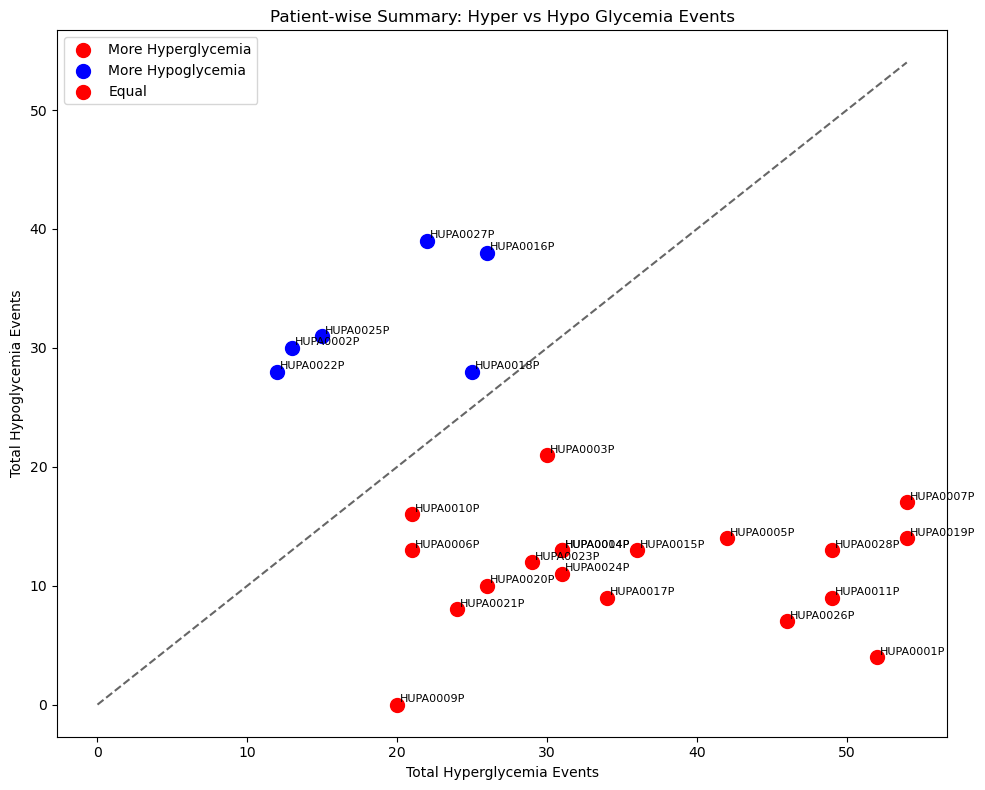

In [80]:
hypo_daily = hypo_events.groupby(['patient_id', 'date']).size().reset_index(name='hypo_events')

# Count hyper events per patient per day
hyper_daily = hyper_events.groupby(['patient_id', 'date']).size().reset_index(name='hyper_events')

# Merge them to get daily_summary
daily_summary = pd.merge(hypo_daily, hyper_daily, on=['patient_id', 'date'], how='outer').fillna(0)

# Convert counts to integer
daily_summary['hypo_events'] = daily_summary['hypo_events'].astype(int)
daily_summary['hyper_events'] = daily_summary['hyper_events'].astype(int)

# Aggregate hyper/hypo event counts across all days per patient
patient_summary = (
    daily_summary.groupby("patient_id")[["hyper_events", "hypo_events"]]
    .sum()
    .reset_index()
)

# Classification
def classify(row):
    if row['hyper_events'] > row['hypo_events']:
        return "More Hyperglycemia"
    elif row['hypo_events'] > row['hyper_events']:
        return "More Hypoglycemia"
    else:
        return "Equal"

patient_summary['status'] = patient_summary.apply(classify, axis=1)
print(patient_summary.head(50))

plt.figure(figsize=(10,8))
colors = {"More Hyperglycemia":"red", "More Hypoglycemia":"blue", "Equal":"green"}

for _, row in patient_summary.iterrows():
    plt.scatter(row['hyper_events'], row['hypo_events'], 
                color=colors[row['status']], s=100)
    plt.text(row['hyper_events']+0.2, row['hypo_events']+0.2, 
             row['patient_id'], fontsize=8)

# Reference line (equal hyper = hypo)
max_val = max(patient_summary['hyper_events'].max(), 
              patient_summary['hypo_events'].max())
plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.6, label="Equal Line")

plt.xlabel("Total Hyperglycemia Events")
plt.ylabel("Total Hypoglycemia Events")
plt.title("Patient-wise Summary: Hyper vs Hypo Glycemia Events")
plt.legend(colors.keys())
plt.tight_layout()
plt.show()

<h3>Key Insights</h3>
<p>Most patients (e.g., HUPA0001P, HUPA0003P, HUPA0004P, etc.) are more affected by <strong>hyperglycemia</strong> → their glucose frequently spikes above the target range.</p>

<p>A smaller group of patients (e.g., HUPA0002P, HUPA0016P, HUPA0018P, etc.) are more affected by <strong>hypoglycemia</strong> → they experience more dangerously low glucose events.</p>

<p>There are no patients with balanced events, indicating that all patients tend to lean towards one type of glycemic risk rather than being equally affected.</p>
<h3>Actions need to take</h3>
<p>Patients with more <strong>hyperglycemia</strong> may need:</p>
<ul>
  <li>Adjustments in insulin doses</li>
  <li>Closer monitoring of meals and carbohydrate intake</li>
  <li>Lifestyle interventions to reduce glucose spikes</li>
</ul>

<p>Patients with more <strong>hypoglycemia</strong> may need:</p>
<ul>
  <li>Preventive monitoring</li>
  <li>Reduced insulin or faster-acting glucose for emergency correction</li>
</ul>

<p>This helps <strong>prioritize interventions</strong>: patients with the largest imbalance may be at higher risk of complications.</p>
--------------------------------------------------------------------------------------------------------------------------------------------------------

<h3>Question 7:</h3>
<p>For each patient, how much physical activity (calories burned) do they perform during hyperglycemia events, and is it sufficient to potentially mitigate the effects of high glucose levels?</p>

<h3>Why It Is Important?</h3>
<ul>
  <li>Physical activity helps lower blood glucose levels and reduce the risk of complications.</li>
  <li>Patients with frequent hyperglycemia but low activity may require targeted lifestyle interventions.</li>
  <li>Monitoring calories burned during high glucose periods provides insight into patient behavior and helps <strong>personalize management plans</strong>.</li>
</ul>


   patient_id  total_calories  avg_calories  num_hyper_events
0   HUPA0001P       10055.502    193.375038                52
1   HUPA0002P        5116.927    393.609769                13
2   HUPA0003P        7487.052    249.568400                30
3   HUPA0004P       16889.290    544.815806                31
4   HUPA0005P        5664.404    134.866762                42
5   HUPA0006P        9030.713    430.033952                21
6   HUPA0007P       23935.817    443.255870                54
7   HUPA0009P       19400.961    970.048050                20
8   HUPA0010P        4449.360    211.874286                21
9   HUPA0011P       11463.169    233.942224                49
10  HUPA0014P       13352.347    430.720871                31
11  HUPA0015P       10686.376    296.843778                36
12  HUPA0016P        9220.916    354.650615                26
13  HUPA0017P       16323.566    480.104882                34
14  HUPA0018P        7325.450    293.018000                25
15  HUPA

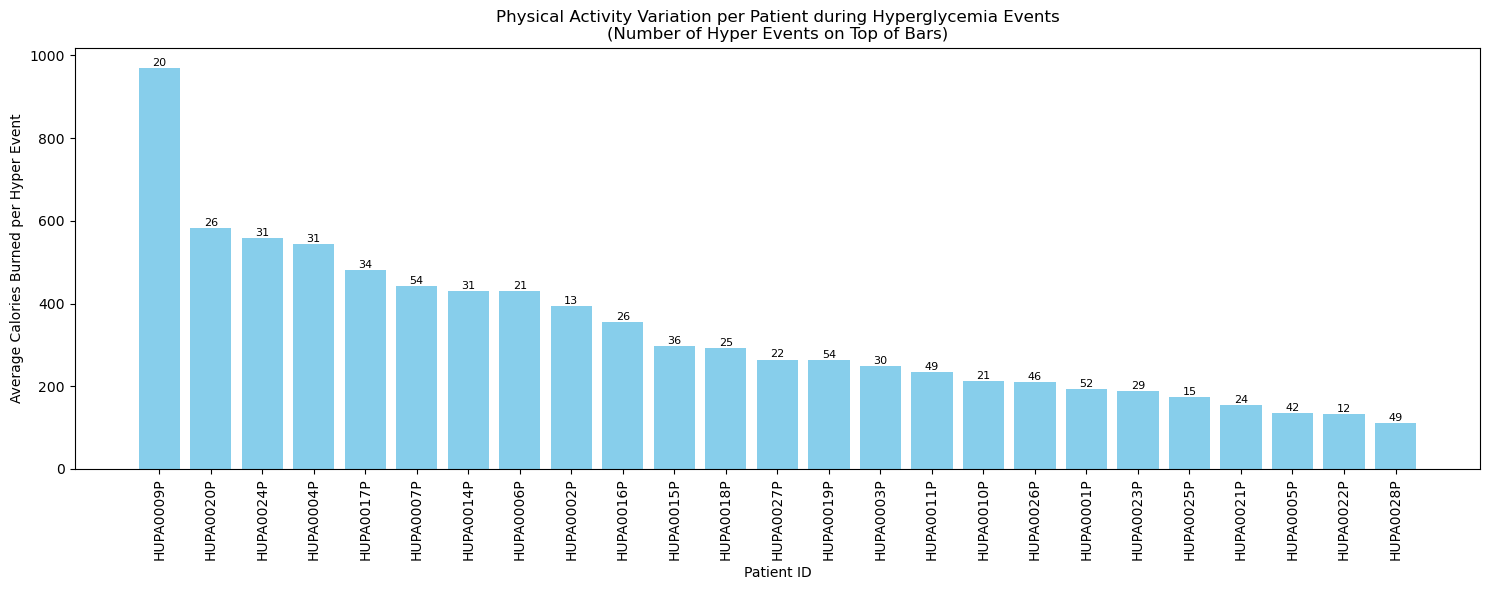

In [83]:

merged_df['datetime'] = pd.to_datetime(merged_df['time'])

# Convert hyper_events times to datetime
hyper_events['start_time'] = pd.to_datetime(hyper_events['start_time'])
hyper_events['end_time'] = pd.to_datetime(hyper_events['end_time'])

# Function to calculate total calories during each hyper event
def calories_during_event(row):
    patient_data = merged_df[merged_df['patient_id'] == row['patient_id']]
    mask = (patient_data['datetime'] >= row['start_time']) & (patient_data['datetime'] <= row['end_time'])
    return patient_data.loc[mask, 'calories'].sum()

# Apply function to hyper_events
hyper_events['calories_burned'] = hyper_events.apply(calories_during_event, axis=1)

# Aggregate per patient
patient_activity_summary = hyper_events.groupby('patient_id')['calories_burned'].agg(
    total_calories='sum',
    avg_calories='mean',
    num_hyper_events='count'
).reset_index()

print(patient_activity_summary)

patient_activity_summary_sorted = patient_activity_summary.sort_values('avg_calories', ascending=False)

plt.figure(figsize=(15,6))
bars = plt.bar(patient_activity_summary_sorted['patient_id'], 
               patient_activity_summary_sorted['avg_calories'], 
               color='skyblue')

# Add num_hyper_events as label on top of each bar
for i, bar in enumerate(bars):
    yval = bar.get_height()
    num_events = patient_activity_summary_sorted.iloc[i]['num_hyper_events']
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, str(num_events), ha='center', fontsize=8, color='black')

plt.xticks(rotation=90)
plt.ylabel("Average Calories Burned per Hyper Event")
plt.xlabel("Patient ID")
plt.title("Physical Activity Variation per Patient during Hyperglycemia Events\n(Number of Hyper Events on Top of Bars)")
plt.tight_layout()
plt.show()

<h3>Key Insight from Result</h3>
<ul>
  <li>There is substantial <strong>variation in physical activity</strong> across patients during hyperglycemia events.</li>
  <li>Some patients burn many calories per event (e.g., HUPA0009P ~970 cal/event), while others burn very few (e.g., HUPA0028P ~112 cal/event).</li>
  <li>Patients with <strong>frequent hyper events and low activity</strong> may be at higher risk and might benefit from <em>increased exercise or structured interventions</em>.</li>
  <li>Patients with <strong>high activity per event</strong> may already be mitigating their hyperglycemia effectively.</li>
</ul>
---------------------------------------------------------------------------------------------------------------------------------------------------------

<h3>Question 8:</h3>
<p>Are patients experiencing frequent hyperglycemia events despite high basal rates?</p>

<h4>Reasoning:</h4><p> it May indicate underestimation of bolus doses or meal timing mismatch.</p>

In [86]:
merged_df['above_range'] = merged_df['glucose_range_level'].str.strip().str.lower() == 'above range'

# Filter only hyperglycemia records
hyper_df = merged_df[merged_df['above_range']].copy()

In [87]:
# Average basal rate per patient during hyperglycemia
basal_summary = hyper_df.groupby('patient_id')['basal_rate'].mean().reset_index()
basal_summary.rename(columns={'basal_rate':'avg_basal_during_hyper'}, inplace=True)

# Total bolus delivered during hyperglycemia per patient
bolus_summary = hyper_df.groupby('patient_id')['bolus_volume_delivered'].sum().reset_index()
bolus_summary.rename(columns={'bolus_volume_delivered':'total_bolus_during_hyper'}, inplace=True)

# Count number of hyperglycemia intervals per patient
hyper_count = hyper_df.groupby('patient_id')['time'].count().reset_index()
hyper_count.rename(columns={'time':'num_hyper_intervals'}, inplace=True)

# Combine all summaries
hyper_analysis = basal_summary.merge(bolus_summary, on='patient_id')\
                             .merge(hyper_count, on='patient_id')

print(hyper_analysis)

   patient_id  avg_basal_during_hyper  total_bolus_during_hyper  \
0   HUPA0001P                0.054486                     69.80   
1   HUPA0002P                0.087849                     57.30   
2   HUPA0003P                0.054532                     69.00   
3   HUPA0004P                0.071456                    221.00   
4   HUPA0005P                0.063733                     43.70   
5   HUPA0006P                0.076283                    104.00   
6   HUPA0007P                0.079843                    226.00   
7   HUPA0009P                0.087644                     95.70   
8   HUPA0010P                0.080223                     32.65   
9   HUPA0011P                0.000000                      0.00   
10  HUPA0014P                0.000000                    105.00   
11  HUPA0015P                0.000000                      0.00   
12  HUPA0016P                0.072559                    121.10   
13  HUPA0017P                0.059000                     60.0

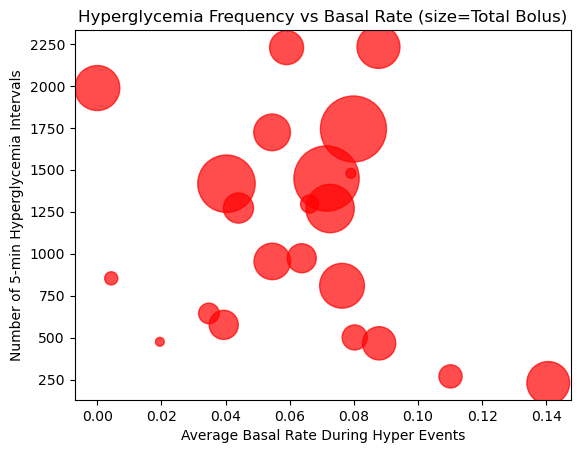

In [88]:
plt.scatter(hyper_analysis['avg_basal_during_hyper'], 
            hyper_analysis['num_hyper_intervals'], 
            s=hyper_analysis['total_bolus_during_hyper']*10, # size by bolus
            alpha=0.7, color='red')

plt.xlabel('Average Basal Rate During Hyper Events')
plt.ylabel('Number of 5-min Hyperglycemia Intervals')
plt.title('Hyperglycemia Frequency vs Basal Rate (size=Total Bolus)')
plt.show()

<html>
<head>
    <title>Hyperglycemia Analysis Recommendations</title>
</head>
<body>
    <h2>Recommendations</h2>
    <ul>
        <li><strong>High basal + high hyper intervals:</strong> Check meal-time bolus strategy; basal alone is insufficient.</li>
        <li><strong>Low basal + high hyper intervals:</strong> Increase basal insulin, especially overnight or fasting periods.</li>
        <li><strong>High bolus but frequent hyper:</strong> Possible timing mismatch or carb-counting issue.</li>
        <li><strong>Low basal & low bolus & low hyper intervals:</strong> Patient is likely well-controlled.</li>
    </ul>

<h2>Key Insights</h2>
    <ul>
        <li>This dataset highlights patterns between insulin delivery and hyperglycemia events.</li>
        <li>Frequent hyperglycemia occurs even in patients with high basal or high bolus insulin.</li>
        <li>Both basal and bolus dosing strategies need review for most patients to reduce hyperglycemia.</li>
        <li>It can be used to prioritize interventions, e.g., adjusting basal profiles, educating on bolus timing, or reviewing diet and carbs.</li>
    </ul>
---------------------------------------------------------------------------------------------------------------------------------------------------------
</body>
</html>